## Purchase Prediction ##
### Project Overview ###

Recommender Systems are to help people discover new content, find the content we were already looking for, discover which things go together, personalize user experiences in response to user feedback, recommend incredible products that are relevant to our interests and identify things that we like, which are basically to model people’s preferences, opinions and behavior.

In this project, we will build a recommender systems to make predictions related to reviews of Books on Amazon. The dataset is 1,000,000 Amazon Book Reviews, which provided us purchase information. Our target was to predict whether the user purchased the item based on these reviews.


### Problem Statement ###

We got 1,000,000 reviews to be used for training, since the dataset is really large, we are not going to use all reviews for training. The fields in this file are:

itemID The ID of the item. This is a hashed product identifier from Amazon.
reviewerID The ID of the reviewer.
rating Rating of the review.
helpful Helpfulness votes for the review.
reviewText The text of the review. 
summary Summary of the review.
unixReviewTime Time of the review in seconds since 1970.
reviewTime Plain-text representation of the review time. 
category Category labels of the product being reviewed.
pairs Purchase.txt Pairs on which you are to predict whether a user purchased an item or not.

Our task is to predict given a (user, item) pair from 'pairs_Purchase.txt' whether the user purchased the item (really, whether it was one of the items they reviewed). The test set has been constructed such that exactly 50% of the pairs correspond to purchased items and the other 50% do not.

In order to solve this problem, we considered three methods. First, the baseline prediction was to find the most popular products that accounts for 50% of purchases in the training data, return '1' whenever such a product is seen at test time, '0' otherwise; Then we applied logistic regression, here we found two ways to generate features and response in training and validation set, we will talk in detail later. Finally, we built an user-based collaborative filtering which was implemented by Jaccard similarity between users. Besides, we refined the percentage threshold that works better than a simple 50% threshold.


In [29]:
import gzip
import math
import sys
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from __future__ import division
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

### Data Exploration ###

The original reviews data is "train.json.gz", we read the data as a list dataset in python. The current reviews list has 1000000 dictionary type objects, which stores review information, here is an example of one of the reviews, each object has 9 features.

In [2]:
# load data
def readGz(f):
    for l in gzip.open(f):
        yield eval(l)

data = []
for l in readGz("train.json.gz"):
    data.append(l)
print "Amazon Book Review Dataset loaded successfully!"

Amazon Book Review Dataset loaded successfully!


In [3]:
data[0]

{'category': [['Books']],
 'helpful': {'nHelpful': 0, 'outOf': 0},
 'itemID': 'I572782694',
 'rating': 5.0,
 'reviewText': 'favorite of the series...May not have been as steamy as some of the others...but the characters, their depth, and believability were amazing.  wanted to curl up with Devlin and make it all better(wink wink). an amazing series...found Laura Kate when I stumbled onto Hearts in Darkness(one of my all time faves)...this series ranks up there with my Kresley Cole and Gena Showalter favorites.',
 'reviewTime': '05 3, 2014',
 'reviewerID': 'U243261361',
 'summary': 'Loved it',
 'unixReviewTime': 1399075200}

In [13]:
# basic statistics
rating = []
review_length = []
helpful_rate = []
unique_user_id = []
unique_item_id = []
time = []

for e in data:
    rating.append(e['rating'])
    review_length.append(len(e['reviewText']))
    unique_user_id.append(e['reviewerID'])
    unique_item_id.append(e['itemID'])
    time.append(e['unixReviewTime'])
    if e['helpful']['outOf'] > 0:
        helpful_rate.append(e['helpful']['nHelpful'] / e['helpful']['outOf'])
    
unique_user_id = set(unique_user_id)
unique_item_id = set(unique_item_id)

# items frequency
item_frequency = defaultdict(int)
total = 0
for e in data:
    user, item = e['reviewerID'], e['itemID']
    item_frequency[item] += 1
    total += 1
        
item_fre = [item_frequency[i] for i in item_frequency]
item_fre.sort()
item_fre.reverse()
    
# users frequency
user_frequency = defaultdict(int)
total = 0
for e in data:
    user, item = e['reviewerID'], e['itemID']
    user_frequency[user] += 1
    total += 1
        
user_fre = [user_frequency[i] for i in user_frequency]
user_fre.sort()
user_fre.reverse()

print "The total number of reviews in this dataset: ", len(data)
print "The total number of users: ", len(unique_user_id)
print "The total number of items: ", len(unique_item_id)
print "Average user frequency: ", sum(user_fre) / len(user_fre)
print "Average item frequency: ", sum(item_fre) / len(item_fre)
print "The average rating: ", sum(rating) / len(rating)
print "The average length of review text: ", sum(review_length) / len(review_length)
print "The average helpful rate: ", sum(helpful_rate) / len(helpful_rate)

 The total number of reviews in this dataset:  1000000
The total number of users:  35736
The total number of items:  37801
Average user frequency:  27.9829863443
Average item frequency:  26.4543266051
The average rating:  4.218463
The average length of review text:  1151.411355
The average helpful rate:  0.738431763713


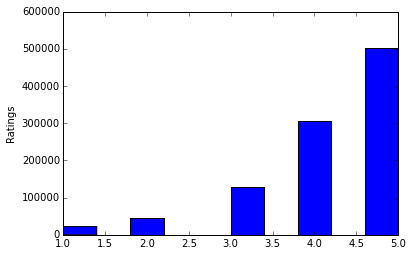

In [40]:
# Data visualization
# histgram of ratings
plt.hist(rating, label = 'Ratings')
plt.ylabel('Ratings')

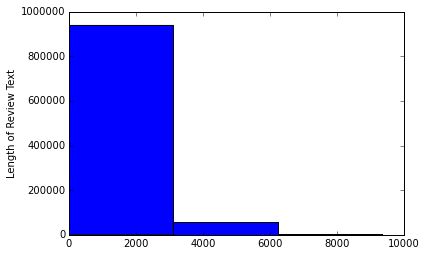

In [26]:
# histgram of review length
plt.hist(review_length)
plt.axis([0, 10000, 0, 1000000])
plt.ylabel('Length of Review Text')

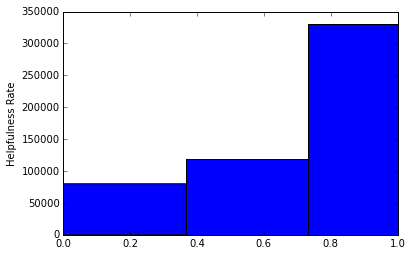

In [27]:
# hist of helpful rate
plt.hist(helpful_rate)
plt.axis([0, 1.0, 0, 350000])
plt.ylabel('Helpfulness Rate')

### Data Preprocessing ###
Although there are lots of features such as reviewText, reviewTime, Summary etc, what we only care about is the purchase information. So we generated user-item pairs from the original dataset and stored them in a list

In [41]:
# generate user-item pairs
all_user = []
all_item = []
for e in data:
    all_user.append(e['reviewerID'])
    all_item.append(e['itemID'])
    
unique_user = list(set(all_user))
unique_item = list(set(all_item))

all_pairs = ['{}-{}'.format(all_user[i], all_item[i]) for i in range(len(all_item))]

In [25]:
print "unique pairs: ", len(set(all_pairs))
all_pairs[0:10]

unique pairs:  1000000


['U243261361-I572782694',
 'U947346309-I172992448',
 'U405075077-I236549536',
 'U931293227-I707281702',
 'U398632015-I127335134',
 'U282193926-I970107598',
 'U681436293-I732947093',
 'U913252976-I273175352',
 'U584647862-I040055669',
 'U887091398-I563838330']

We need to think harder to generate a validation set for this data. Instead of just taking the last 100k reviews for validation, we instead took 50,000, but also randomly select 50,000 'non-purchases' by randomly selecting a user and an item, and checking that they do not already show up together in the training set.

In [42]:
# generate non_purchased half
length = 0
while length < 50000:
    user = list(np.random.choice(unique_user, size = 70000, replace = True))
    item = list(np.random.choice(unique_item, size = 70000, replace = True))
    select = set(['{}-{}'.format(user[i], item[i]) for i in range(len(item))])
    select = select.difference(set(all_pairs[0:100000]))
    select = select.difference(set(all_pairs[950000:]))
    length = len(select)

non_purchase = list(np.random.choice(list(select), size = 50000, replace = False))

In [43]:
non_purchase[0:10]

['U501478638-I507471294',
 'U380506315-I820654026',
 'U780033890-I254842988',
 'U764574234-I898493465',
 'U558625745-I143437438',
 'U307898551-I092906927',
 'U978009713-I686717301',
 'U569185065-I897859165',
 'U148756148-I071552252',
 'U147006061-I936415489']

Since the data is quite large, it will be too time-consuming to work with all 1 million training examples, also since we don’t have access to the test labels. We will need to simulate validation/test sets of our own. Now we split the training data as follows:
Reviews 1-100,000 for training
Reviews 950001 - 1,000,000 + 50,000 non-purchases for validation

In [44]:
# generate training and validation set

train_set = all_pairs[0: 900000]
val_set = all_pairs[950000: ] + non_purchase

### Metrics ###
In the test data, we are given pairs like these:

userID - itemID,          			prediction

U321264570-I114057426

U746082164-I893042700

U370790476-I428256969

U914546038-I075600973

We need to estimate the final column, predict '1' if the user purchased the item, otherwise predict '0'. The evaluation for this task is the categorization accuracy (fraction of instances labeled correctly), which is defined as: 1 - Hamming loss(fraction of misclassifications) 

In [45]:
# define metrics
def accuracy(pred):
    length = len(pred)
    acc = 0
    for i in range(0, int(length/2)):
        if pred[i] == 1:
            acc = acc + 1
    for i in range(int(length/2), length):
        if pred[i] == 0:
            acc = acc + 1
    acc = acc/length
    return acc

## Models and Inplementation ##
### Baseline popularity model: ### 
the baseline for this task simply ranks products by popularity, and returns '1' for popular products, by finding the most popular product that account for 50% of purchases. 

In [97]:
# basic popularity model
def basic_popu_model(train, threshold):
    '''
    function to select the most popular items(purcahsed number > total purchased number * threshold)
    
    input: list of user-item pairs, threshold
    
    output: a list of most popular items 
    '''
    item_count = defaultdict(int)
    total = 0
    for e in train:
        user, item = e.split('-')
        item_count[item] += 1
        total += 1
        
    popularity = [(item_count[i], i) for i in item_count]
    popularity.sort()
    popularity.reverse()
    
    result = set()
    count = 0
    
    for c, i in popularity:
        count += c
        result.add(i)
        if count > total*threshold: break
    return result

def pred_popu_model(train, test, threshold):
    '''
    predict if item in each pair belongs to most popular items
    
    input: traning set(list), testing set(list), threshold
    
    output: prediction result, a list of 1 or 0
    '''
    rst = basic_popu_model(train, threshold)
    pred = []
    for e in test:
        user, item = e.split('-')
        if item in rst:
            pred.append(1)
        else:
            pred.append(0)  
    return pred

pred1 = pred_popu_model(train_set, val_set, 0.5)
print "the accuracy of the baseline on the validation set is:", accuracy(pred1)

the accuracy of the baseline on the validation set is: 0.63692


In [98]:
# select the best threshold
acc = []
threshold = np.arange(0.1, 1, 0.01)
for t in threshold:
    temp_pred = pred_popu_model(train_set, val_set, t)
    acc.append(accuracy(temp_pred))

best_threshold = threshold[np.argmax(acc)]
best_accuracy = np.max(acc)
print 'best threshold: ', best_threshold
print 'best accuracy: ', best_accuracy

best threshold:  0.56
best accuracy:  0.63851


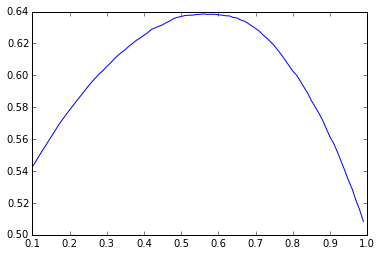

In [100]:
# draw scatter plot displaying the accuracy of different threshold
plt.plot(threshold, acc)

In [101]:
# basic popularity model
def basic_user_popu_model(train, threshold):
    '''
    function to select the most popular users(purcahsed number > total purchased number * threshold)
    
    input: list of user-item pairs, threshold
    
    output: a list of most popular users 
    '''
    user_count = defaultdict(int)
    total = 0
    for e in train:
        user, item = e.split('-')
        user_count[user] += 1
        total += 1
        
    popularity = [(user_count[i], i) for i in user_count]
    popularity.sort()
    popularity.reverse()
    
    result = set()
    count = 0
    
    for c, i in popularity:
        count += c
        result.add(i)
        if count > total*threshold: break
    return result

def pred_user_popu_model(train, test, threshold):
    '''
    predict if user in each pair belongs to most popular items
    
    input: traning set(list), testing set(list), threshold
    
    output: prediction result, a list of 1 or 0
    '''
    rst = basic_user_popu_model(train, threshold)
    pred = []
    for e in test:
        user, item = e.split('-')
        if user in rst:
            pred.append(1)
        else:
            pred.append(0)  
    return pred

pred2 = pred_user_popu_model(train_set, val_set, 0.5)
print "the accuracy of the user baseline on the validation set is:", accuracy(pred2)

the accuracy of the user baseline on the validation set is: 0.65164


In [102]:
# select the best threshold
acc = []
threshold = np.arange(0.1, 1, 0.01)
for t in threshold:
    temp_pred = pred_user_popu_model(train_set, val_set, t)
    acc.append(accuracy(temp_pred))

best_threshold = threshold[np.argmax(acc)]
best_accuracy = np.max(acc)
print 'best threshold: ', best_threshold
print 'best accuracy: ', best_accuracy

best threshold:  0.6
best accuracy:  0.65647


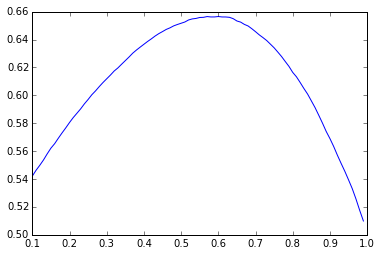

In [103]:
# draw scatter plot displaying the accuracy of different threshold
plt.plot(threshold, acc)

### logistic regression: ####
1. X should be an one-zeroes matrix, each row represents for each user-item pair
   
2. The training set here are all 'purchased', which means
    y_train = [1,1,..,1], So we use popularity of item as 
    new y_train, which is the prediction of training set

3. parameters will be fit by logistic regression, and chosen by differenct threshold         

In [84]:
# example of building feature matrix X
vec = DictVectorizer(sparse = False)
x = [{'user': 'user1', 'item': 'item3'}, 
     {'user': 'user2', 'item': 'item1'},
     {'user': 'user3', 'item': 'item2'}]
matrix = vec.fit_transform(x)
matrix

array([[ 0.,  0.,  1.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.]])

In [78]:
X_temp

[{'item': 'I572782694', 'user': 'U243261361'},
 {'item': 'I172992448', 'user': 'U947346309'}]

In [104]:
def user_logistic(train, test, threshold):
    '''
    a function to train logistic regression model
    make a prediction of testing set and get accuracy
    
    input: training set(list), testing set(list), threshold(numeric)
    
    output: accuracy of the model, prediction result(a list of 1 or 0)
    '''
    
    # generate new y_train
    y_train = pred_user_popu_model(train, train, threshold)
    
    # generate new x_train
    v = DictVectorizer()
    X_temp = [{"user": e.split('-')[0], "item": e.split('-')[1]} for e in train]
    X_train = v.fit_transform(X_temp)
    
    # fit_logistic
    clf = LogisticRegression()
    clf.fit(X_train, y_train) 
    
    # generate new x_val
    X_tmp = [{"user": e.split('-')[0], "item": e.split('-')[1]} for e in test]
    X_val = v.transform(X_tmp)
    
    pred = clf.predict(X_val)
    
    return accuracy(pred), pred

print 'The accuracy of logistic regression(threshold = 0.5):', user_logistic(train_set, val_set, 0.5)[0]

The accuracy of logistic regression(threshold = 0.5): 0.65164


In [105]:
# select the best threshold
acc = []
threshold = np.arange(0.1, 1, 0.01)
for t in threshold:
    acc.append(user_logistic(train_set, val_set, t)[0])

best_threshold = threshold[np.argmax(acc)]
best_accuracy = np.max(acc)
print 'best threshold: ', best_threshold
print 'best accuracy: ', best_accuracy

best threshold:  0.6
best accuracy:  0.65647


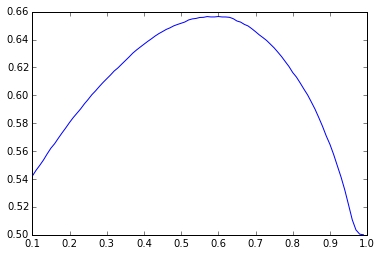

In [106]:
# draw scatter plot displaying the accuracy of different threshold
plt.plot(threshold, acc)

### User-based Collaborative Filtering: ####
This is a method performs recommendation in terms of user/user similarity. This method was implemented by Jaccard Similarity between users. Jaccard Similarity between users is defined as the intersection of two users divided by the union of them.

To predict a pair of user and item, say U1-I1, we checked any other users who purchased I1, say Ui, if the Jaccard similarity between U1 and Ui is positive(which means they have common purchase), then we predicted U1-I1 as '1', otherwise is '0'. Here, because this model is time-consuming when test set is large, so we reduced the validation set to 5000.

In [89]:
val = all_pairs[999500: ] + non_purchase[0:500]

In [49]:
# Build utility matrix
train_user = []
train_item = []
for e in train_set:
    user, item = e.split('-')
    train_user.append(user)
    train_item.append(item)
    
unique_user = list(set(train_user))
unique_item = list(set(train_item))
    
rating = [1 for i in range(len(train_user))]
d = {'user': pd.Series(train_user), 
    'item': pd.Series(train_item), 
    'rating': pd.Series(rating)}
df = pd.DataFrame(d)    
table = df.pivot_table(index = 'user', columns = 'item', values = 'rating')

In [75]:
# example
u = ['user1', 'user2', 'user3', 'user1', 'user3']
i = ['item3', 'item1', 'item2', 'item1', 'item3']

r = [1 for i in range(len(a))]
series = {'user': pd.Series(a), 
    'item': pd.Series(b), 
    'rating': pd.Series(r)}
df = pd.DataFrame(series)    
tb = df.pivot_table(index = 'user', columns = 'item', values = 'rating')
tb

item,item1,item2,item3
user,,,
user1,1,NaN,1
user2,1,NaN,NaN
user3,NaN,1,1


In [90]:
def similarity_model(train, test):
    '''
    A function to train and predict collaborative filtering model
    
    input: training set(list), testing set(list)
    
    output: result of prediction(a list of 1 or 0), accuracy(numeric)
    '''
    
    pred = []
    # predict each pair
    for e in test:
        user, item = e.split('-')
        if user in train_user and item in train_item:
            col = table[item]
            temp_users = col[col == 1].index.tolist()
            
            # measure the similarity of other users who also purchased the item in the pair
            # and the user in the pair
            has_common = False
            for u in temp_users:
                if u != user:
                    row1 = table.loc[user]
                    row2 = table.loc[u]
                    common = set(row1[row1 == 1].index.tolist()) & set(row2[row2 == 1].index.tolist())
                    if len(common) != 0:
                        has_common = True
                        break
                        
            # if similarity is positive, predict user-item as 1
            # otherwise as 0
            if has_common:
                pred.append(1)
            else:
                pred.append(0)
        else:
            pred.append(0)
    return pred, accuracy(pred)
    
print "The accuracy: ", similarity_model(train_set, val)[1]

The accuracy:  0.771


In [95]:
# Running 20 times of collaborative filtering model
for i in range(0, 20):
    val = list(np.random.choice(all_pairs[900000:], size = 500, replace = False)) + list(np.random.choice(non_purchase, size = 500, replace = False))
    print similarity_model(train_set, val)[1]

0.774
0.788
0.775
0.761
0.795
0.8
0.793
0.769
0.766
0.779
0.794
0.788
0.795
0.784
0.8
0.8
0.769
0.776
0.782
0.798


In [96]:
# applied T test to test if accuracy of collaborative filtering 
# is significantly larger than benchmark
from scipy import stats

acc = np.array([0.774, 0.788, 0.775, 0.761, 0.795, 0.8, 0.793, 0.769, 0.766, 0.779, 0.794, 0.788, 0.795, 0.784, 0.8, 0.8, 0.769, 0.776, 0.782, 0.798])
benchmark = 0.65
stats.ttest_1samp(acc, benchmark)

(47.843991875817743, 2.8563340903465752e-21)

In [109]:
# compute the average accuracy of different methods
acc_popu_item = []
acc_popu_user = []
acc_logi = []
for i in range(0,20):
    temp_pred = pred_popu_model(train_set, val_set, 0.56)
    acc_popu_item.append(accuracy(temp_pred))
    
    temp_pred = pred_user_popu_model(train_set, val_set, 0.6)
    acc_popu_user.append(accuracy(temp_pred))
    
    acc_logi.append(user_logistic(train_set, val_set, 0.6)[0])

acc_cf = [0.774, 0.788, 0.775, 0.761, 0.795, 0.8, 0.793, 0.769, 0.766, 0.779, 0.794, 0.788, 0.795, 0.784, 0.8, 0.8, 0.769, 0.776, 0.782, 0.798]
average = [np.mean(acc_popu_item), np.mean(acc_popu_user), 
           np.mean(acc_logi), np.mean(acc_cf)]

In [118]:
# Draw table to compare average accuracy of different methods
model = ['item popularity', 'user popularity', 'logistic regression', 'collaborative filtering']
          
d = {'Average Accuracy': pd.Series(average, index = model)}
df = pd.DataFrame(d)  
df

,Average Accuracy
item popularity,0.63851
user popularity,0.65647
logistic regression,0.65647
collaborative filtering,0.78430


## Result: ##
### Model Evaluation and Validation ###

Compared the performance of three methods:
Baseline Popularity Model: the most efficiency model, very fast, but the performance is not good as my expectation. The user popularity model performs better than the item popularity model, the best performance of the user popularity model is 0.63357.

Logistic Regression: slower than the baseline popularity model, the performance is similar to the baseline popularity model.

User-Based Collaborative Filtering: Performs best with really high accuracy, but when test set is large, this method is slower than the above two. The accuracy is 0.95 on the validation set.

Although the collaborative filtering is the slowest one, we still considered this model as our final model, since it’s performance is really good compare to the baseline and logistic regression.

### Justification ###

Finally we decided to use user-based collaborative filtering to do prediction, the result of the validation set is around 0.95 which is higher than the accuracy we expected. 

But the accuracy was got by just testing on 10000 validation set, which is not large enough, so the reliability of the accuracy should be doubted. But we still have reason to justify that the collaborative filtering works better than the baseline and logistic regression, this is because when generated the validation set in the first two methods, we got non-purchase data set by generation instead of from real world, so the validation set is not as reliable as what we used in the last model.

## Conclusion: ##
### Reflection ###

This project is a recommender system problem, the main idea is to evaluate people’s preference and purchase habits and make some recommendations. In this specific problem, we are given 1 million Amazon book reviews, which provided us purchase information, our target is to predict when user purchased the item given some user-item pairs. 

To solve the problem, first we generate a user-item list from the original list of review information. Then we reconstruct the training and validation data by randomly selecting user-item pairs which do not show up in the training set as non-purchase pairs. As for models, we considered three models: popularity model, logistic regression and collaborative filtering. For popularity model, we considered the most popular pairs as label 1; for logistic regression, we combined the popularity in popularity model as a feature in logistic regression model, in other words, we use the prediction of popularity model on training set as the model response, and then transform the feature list to one-zeroes matrix to fit the model; for collaborative filtering, we implemented this model by using Jaccard similarity to measure the similarity between users and evaluated users’ preference. 

This problem is useful and practical in the real life, but since the dataset is quite large, working on the whole dataset is time-consuming, maybe we should come up with some other more efficiency and effective models.

### Improvement ###

We still have a few problems left to address:

1) Collaborative filtering in practice is kind of slow given a huge enough dataset, if one user purchases one item, this will change the rankings of every other item that was purchased by at least one user in common.

2) In practice, this may have "cold start" problem when there is no use for new users and new items.

3) In reality, the non-purchase pairs will be comparatively larger than purchased pairs, so the metrics of using accuracy may not be a good idea in practice, we should consider assign additional weight to negative instances, for example, F_1 score.